# Script to aquire and pre-process OSM data to an Xarray cube

In [ ]:
##### Import libraries ######
# system
import os
import re
import time
import threading
import multiprocessing as mp
from concurrent.futures import ThreadPoolExecutor, as_completed
import logging
import traceback
import random

# data manipulation
from array import array
import yaml
import duckdb
import json
import overpass
import numpy as np
import pandas as pd
import geopandas as gpd
from pandas.api.extensions import register_dataframe_accessor
import xarray as xr
import rioxarray as rxr # needed for all rasterio operations on xarray even if not called directly
from rasterio.transform import from_bounds
from rasterio.features import rasterize
from shapely.geometry import Polygon
from shapely import wkb
import geoarrow.pyarrow as ga
import utm
from pyproj import CRS

# visualization
from tqdm import tqdm

#### Function to exit on error ######
def exit_with_error(message):
    print(message)
    print("Finishing due to error at", time.strftime("%Y-%m-%d %H:%M:%S"))
    exit(1)

###### setup config variables #######
repo_name = 'masterthesis_genai_spatialplan'
if not repo_name in os.getcwd():
    os.chdir(repo_name)

p=os.popen('git rev-parse --show-toplevel')
repo_dir = p.read().strip()
p.close()

config = {}
with open(f"{repo_dir}/config.yml", 'r') as stream:
    config = yaml.safe_load(stream)
    
region = config['regions'][0]  # e.g. 'dresden'

# setup folders
big_data_storage_path = config.get("big_data_storage_path", "/work/zt75vipu-thesis/data")
osm_region_folder = f"{big_data_storage_path}/osm/{region.lower()}"
os.makedirs(osm_region_folder, exist_ok=True)

osm_zarr_name = f"{osm_region_folder}/osm_rasterized.zarr"

print("Processing region:", region, "at", time.strftime("%Y-%m-%d %H:%M:%S"), "to produce zarr file:", osm_zarr_name)

Processing region: Dresden at 2025-10-22 14:34:12 to produce zarr file: D:/master_thesis/data/osm/dresden/osm_rasterized.zarr


In [3]:
######## Try except Planet data processing ########
try:
    if os.path.exists(osm_zarr_name):
        print(f"OSM data already exists at {osm_zarr_name}, skipping processing.")
        # exit(0)
        
except Exception as e:
    print(f"An error occurred: {e}")
    exit_with_error(f"An error occurred: {e}")

In [10]:
############ Define the bbox ############ 
ghsl_df_new = gpd.read_parquet(f"{repo_dir}/data/processed/ghsl_regions.parquet")
bbox_gdf = gpd.GeoDataFrame(geometry=ghsl_df_new[ghsl_df_new["region_name"]==region].bbox, crs="EPSG:4326")
bbox_polygon=json.loads(bbox_gdf.to_json())['features'][0]['geometry']
bbox = bbox_gdf.total_bounds
coordinates=json.loads(bbox_gdf.geometry.to_json())["features"][0]["geometry"]["coordinates"]

# get utm zone
easting, northing, zone_number, zone_letter = utm.from_latlon(bbox_gdf.geometry.centroid.y.values[0], bbox_gdf.geometry.centroid.x.values[0])
is_south = zone_letter < 'N'  # True for southern hemisphere
utm_crs = CRS.from_dict({'proj': 'utm', 'zone': int(zone_number), 'south': is_south})
print(f"UTM CRS: {utm_crs.to_authority()} with zone {zone_number}{zone_letter}")


# Create a grid for multithreading
# xmin, ymin, xmax, ymax = gdf.total_bounds
length = 0.03
width = 0.03

xmin, ymin, xmax, ymax = bbox_gdf.total_bounds

cols = list(np.arange(xmin, xmax + width, width))
rows = list(np.arange(ymin, ymax +length, length))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([
            (x, y), (x+width, y), (x+width, y+length), (x, y+length)
        ]))
grid = gpd.GeoDataFrame(geometry=polygons, crs="EPSG:4326")

UTM CRS: ('EPSG', '32633') with zone 33U


C:\Users\janne\AppData\Local\Temp\ipykernel_3272\978108952.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  easting, northing, zone_number, zone_letter = utm.from_latlon(bbox_gdf.geometry.centroid.y.values[0], bbox_gdf.geometry.centroid.x.values[0])


In [3]:
######### Request the OpenStreetMap Data ########
filename_all_features=f"{osm_region_folder}/osm_gdf.parquet"

# Define the tag to query
tags = {
    "building": True,
    "waterway": True,
    # "natural": True,
    "natural": ["water", "wood", "grassland", "wetland", "scrub", "heath", "moor", "bay", "beach", "sand", "mud"],
    "highway": True,
    "boundary": ["protected_area"],
    "landuse": True,
    "leisure": ["park", "garden", "playground", "pitch", "sports_centre"],
    "place": ["square"],
    "amenity": ["fountain", "school", "university", "college", "hospital", "kindergarten", "place_of_worship", "parking"],
    "aeroway": True,
    "railway": True,
}

# Suppress logs for the Overpass API requests
def suppress_overpass_logs():
    logging.getLogger("urllib3").setLevel(logging.CRITICAL)
    logging.getLogger("requests").setLevel(logging.CRITICAL)
    logging.getLogger("osm2geojson").setLevel(logging.WARNING)

def restore_logs():
    # Restore the default logging level
    logging.getLogger("urllib3").setLevel(logging.NOTSET)
    logging.getLogger("requests").setLevel(logging.NOTSET)
    logging.getLogger("osm2geojson").setLevel(logging.NOTSET)
    
# threading parameters
max_concurrent = 6      # parallel requests to Overpass API

# Create Overpass query for tags
def create_query(bbox, tags):
    query_parts = []
    
    south, west, north, east = bbox[1], bbox[0], bbox[3], bbox[2]

    for tag, value in tags.items():
        osm_graph_type = "wr"  # nwr, node, way, etc.
        
        if tag in {"building","highway","railway","waterway"}:
            osm_graph_type = "way"
            
        if value is True:
            # If true, use tag
            query_parts.append(f'{osm_graph_type}["{tag}"]({south},{west},{north},{east});')
        elif isinstance(value, list):
            # If list, use a regex match for multiple possible values
            vals = [str(v) for v in value]
            if len(vals) == 1:
                v = vals[0]
                query_parts.append(f'{osm_graph_type}["{tag}"="{v}"]({south},{west},{north},{east});')
            else:
                pat = "|".join(re.escape(v) for v in vals)
                query_parts.append(f'{osm_graph_type}["{tag}"~"{pat}"]({south},{west},{north},{east});')
        else:
            # If single string, use an exact match
            query_parts.append(f'{osm_graph_type}["{tag}"="{value}"]({south},{west},{north},{east});')

            
    #join to a single query
    query = "("+"\n".join(query_parts) +");"
    # members = "(._;>>;);"
    # return query + members + "out body geom;"
    return query


# Initialize the Overpass API
overpass_api = overpass.API(debug=False, timeout=900)

def fetch_overpass_data(bbox, tags, retries=10, delay=2):
    
    query = create_query(bbox, tags)
    
    for attempt in range(retries):
        try:
            suppress_overpass_logs()
            response = overpass_api.Get(query, responseformat="geojson", verbosity='geom')
            restore_logs()
            
            # print(f"Fetched {len(response['features'])} features for bbox {bbox}")
            
            gdf = gpd.GeoDataFrame.from_features(response['features']) 
            
            #drop nodes column
            if 'nodes' in gdf.columns:
                gdf = gdf.drop(columns=['nodes'])

            #create columns for tags
            if 'tags' in gdf.columns:
                # new dataframe from tags
                expanded_tags = pd.json_normalize(gdf['tags'])
                
                # Only keep columns with at least 50% data for tags
                threshold = len(expanded_tags) * 1/len(tags)*0.5
                columns_to_drop = [col for col in expanded_tags.columns if 
                                expanded_tags[col].count() < threshold and 
                                col not in ["natural", "water", "boundary", "landuse", "building", "highway", "waterway"]]
                expanded_tags = expanded_tags.drop(columns=columns_to_drop)
                gdf = gdf.drop(columns=['tags'])
                
                # concatenate with original dataframe
                gdf = pd.concat([gdf, expanded_tags], axis=1)
                
                # for duplicated column names, keep the first one
                gdf = gdf.loc[:,~gdf.columns.duplicated()]

            return gdf
        
        except overpass.errors.ServerLoadError as e:
            # server loaded, use return time to wait
            sleep_s = (e.args[0] if e.args else 10) + random.uniform(0.5, 2.0)
            print(f"ServerLoadError on attempt {attempt+1}. Retrying after delay.", sleep_s)
            time.sleep(sleep_s)

        except overpass.errors.MultipleRequestsError:
            print(f"MultipleRequestsError on attempt {attempt+1}. Retrying after delay.")
            # collided with another job, wait with jitter
            time.sleep(2.0 + random.uniform(0.2, 1.5))
        
        except Exception as e:
            etype = type(e).__name__
            args = getattr(e, "args", ())
            resp = getattr(e, "response", None)
            resp_info = ""
            if resp is not None:
                try:
                    resp_info = f" | HTTP {resp.status_code}: {resp.text[:500]}"
                except Exception:
                    pass
            print(f"Error fetching data for bbox {bbox}: {etype} args={args}{resp_info}")
            print(traceback.format_exc())
            time.sleep(delay)
            
    print(f"Failed to fetch data after {retries} attempts.")
    return None

if not os.path.exists(filename_all_features):
    ###Download for the whole region, separate by layers and convert features to xarray 
    # Multithreaded feature extraction for the grid
    def extract_features_grid(grid, tags):
        features = []
        with ThreadPoolExecutor(max_workers=max_concurrent) as executor:
            futures = {executor.submit(fetch_overpass_data, row.geometry.bounds, tags): row for _, row in grid.iterrows()}
            for future in tqdm(as_completed(futures), total=len(futures)):
                try:
                    features.append(future.result())
                except Exception as e:
                    print(f"Error: {e}")
        return pd.concat(features, ignore_index=True)

    # Execute the function
    osm_gdf = extract_features_grid(grid, tags)

    # Clean geometry
    osm_gdf = osm_gdf[osm_gdf.geometry.is_valid]

    #remove duplicates by id
    osm_gdf = osm_gdf.drop_duplicates(subset=['id'])

    #set crs
    osm_gdf.crs = "EPSG:4326"

    #display summary of features
    print(f"Number of features: {len(osm_gdf)}")
    print("\nFeature types:")
    print(osm_gdf['geometry'].type.value_counts())

    #### Write to parquet for easier access ######
    osm_gdf.to_parquet(filename_all_features, index=False)
else:
    print(f"OSM data already exists at {filename_all_features}, skipping download.")
    
    #read from parquet
    osm_gdf = gpd.read_parquet(filename_all_features)

#filter out invalid geometries
osm_gdf = osm_gdf[osm_gdf.geometry.is_valid]

OSM data already exists at D:/master_thesis/data/osm/dresden/osm_gdf.parquet, skipping download.


<Axes: >

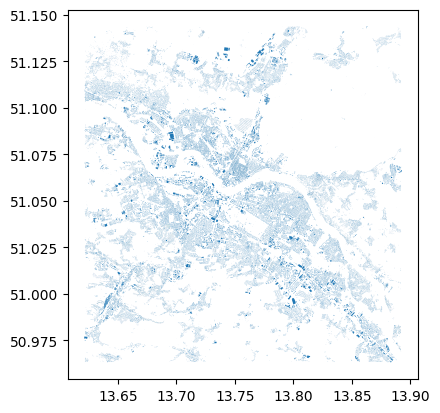

In [6]:
osm_gdf[osm_gdf["building"].notnull()].plot()

In [4]:
#### Extend geopandas DataFrame object by a conversion class to xarray raster dataarrays ######
if "to_raster" in pd.DataFrame._accessors:
    # in case you need to change the accessor function, this removes the old one
    # you'd have to reassign old gdfs afterwards, however --> new_gdf = gpd.GeoDataFrame(old_gdf)
    pd.DataFrame._accessors.remove("to_raster")
    delattr(pd.DataFrame, "to_raster")

@register_dataframe_accessor("to_raster")
class XarrayAccessor:
    def __init__(self, gdf):
        self._gdf = gdf

    def rasterize_gdf(self, bbox, image_size=1024, col=None, nodata=0):
        """
        Rasterizes the GeoDataFrame with rio rasterize.
        
        Parameters:
        self (GeoDataFrame): 
            The GeoDataFrame to rasterize.
        bbox (tuple):
            The bounding box of the area to rasterize (xmin, ymin, xmax, ymax).
        image_size (int): 
            The size of the output raster image.
        col (str): 
            Optional column name to use for rasterization values.
        """
        
        shapes = None
        if col:
            #remove none/nan values from the column
            self._gdf = self._gdf[self._gdf[col].notnull()]
            if not pd.api.types.is_numeric_dtype(self._gdf[col]):
                #enumerate the unique values in the non-numeric column
                df_mapping = {value: idx+1 for idx, value in enumerate(self._gdf[col].unique())}  
                self._gdf.loc[:,f"{col}_int"] = self._gdf[col].map(df_mapping)
                shapes = ((geom, value) for geom, value in zip(self._gdf.geometry, self._gdf[f"{col}_int"]))
            else:
                shapes = ((geom, value) for geom, value in zip(self._gdf.geometry, self._gdf[col]))
        else:
            shapes = self._gdf.geometry.values
            
        xmin, ymin, xmax, ymax = bbox

        return rasterize(
            shapes,
            out_shape=(image_size, image_size),
            fill=nodata,
            transform=from_bounds(xmin, ymin, xmax, ymax, image_size, image_size),
            all_touched=True,
            dtype=np.float32
        )

    def to_xr_dataarray(self, bbox, image_size, x_coords, y_coords, name="data", long_name=None, description=None, 
                    mapping_col=None, output_path=None, crs="EPSG:4326", x_dim="lon", y_dim="lat", units="1", nodata=0):
    
        """
        Process the GeoDataFrame, convert to a xarray DataArray, and optionally save to a zarr file. 
        
        Parameters:
        -----------
        self (GeoDataFrame):
            The GeoDataFrame to convert
        transform (Affine):
            The affine transformation to apply
        image_size (int):
            The size of the output raster image
        x_space (numpy.ndarray):
            The x coordinate space
        y_space (numpy.ndarray):
            The y coordinate space
        mapping_col (str, optional):
            Column name for mapping
        output_path (str, optional):
            Path to save the output zarr file
            
        Returns:
        --------
        xarray.DataArray
            The xarray DataArray with the rasterized data
        """
    
        xmin, ymin, xmax, ymax = bbox
        
        shapes = None
        df_mapping = None
        if mapping_col:
            # remove none/nan values from the column
            self._gdf = self._gdf[self._gdf[mapping_col].notnull()]
            if not pd.api.types.is_numeric_dtype(self._gdf[mapping_col]):
                #enumerate the unique values in the non-numeric column
                df_mapping = {value: idx+1 for idx, value in enumerate(self._gdf[mapping_col].unique())}  
                self._gdf.loc[:,f"{mapping_col}_int"] = self._gdf[mapping_col].map(df_mapping)
                shapes = ((geom, value) for geom, value in zip(self._gdf.geometry, self._gdf[f"{mapping_col}_int"]))
            else:
                shapes = ((geom, value) for geom, value in zip(self._gdf.geometry, self._gdf[mapping_col]))
        else:
            shapes = self._gdf.geometry.values
            
        

        raster = rasterize(
            shapes,
            out_shape=(image_size, image_size),
            fill=nodata,
            transform=from_bounds(xmin, ymin, xmax, ymax, image_size, image_size),
            all_touched=True,
            dtype=np.float32
        )

        #y_coords = np.flipud(y_coords) # flip y coordinates to match the raster
        coords = {y_dim: y_coords, x_dim: x_coords}
        da = xr.DataArray(raster, dims=[y_dim, x_dim], coords=coords)
        da = da.rio.write_crs(crs)
        da = da.rio.set_spatial_dims(x_dim=x_dim, y_dim=y_dim)
        da = da.rio.set_nodata(nodata)

        da.name = name
        da.attrs.update({
            "long_name": long_name or name,
            "description": description or f"Rasterized {name} data",
            "units": units,
            "spatial_ref": crs,
            "crs": crs,
        })
    
        if df_mapping:
            da.attrs[f"{name}_mapping"] = json.dumps(df_mapping)

        if output_path:
            da.to_zarr(output_path, mode="w", consolidated=True, compute=True)

        return da
    
# Create the lat/lon coordinates and transform for the raster
image_size = config["osm_query"].get("image_size", 5500)
lat = np.linspace(ymax, ymin, image_size) # the affine transform of rasterio inverts the y axis, so our lat space has to be inverted for correct xarray coordinates
lon = np.linspace(xmin, xmax, image_size)

######### Create the rasterized datasets #########
print("Creating rasterized datasets from OSM data...")

#### Retrieve street lines, set a more appropriate width and convert to xarray ds
print("Retrieving streets from OSM data...")
types_folder_path= f"{osm_region_folder}/types"
os.makedirs(types_folder_path, exist_ok=True)

Creating rasterized datasets from OSM data...
Retrieving streets from OSM data...


In [ ]:
streets_zarr_name = f"{types_folder_path}/rasterized_streets.zarr"

if not os.path.exists(streets_zarr_name):
    # Note: the column 'smootheness' is the "physical usability of a way for wheeled vehicles, particularly regarding surface regularity/flatness" https://wiki.openstreetmap.org/wiki/Key:smoothness

    #filter out streets
    streets_gdf = osm_gdf[osm_gdf["highway"].notnull()]
    streets_gdf = streets_gdf[streets_gdf.geometry.type == "LineString"]

    #remove all columns where more than 50% nans
    streets_gdf = streets_gdf.dropna(axis=1, thresh=len(streets_gdf) * 0.5)

    #rename lit to lighting
    streets_gdf = streets_gdf.rename(columns={"lit": "lighting"})

    # Convert to polygons with width by feature based buffering
    # The width for german streets is managed by:
    # - Richtlinien für die Anlage von Autobahnen https://www.fgsv-verlag.de/raa-guidelines-for-the-design-of-motorways-edition-2008-translation-2011-englische-ubersetzung
    # - Richtlinien für die Anlage von Landstraßen https://www.bast.de/DE/Verkehrstechnik/Fachthemen/v1-strassentypen.html
    # The following simplifies the values for the different highway classes:

    # create a dict for highway classifications and their corresponding widths
    widths = {
        'motorway': 24,
        'motorway_link': 16,
        'trunk': 24,
        'trunk_link': 16,
        'primary': 15,
        'primary_link': 12,
        'secondary': 12,
        'secondary_link': 11,
        'tertiary': 11,
        'tertiary_link': 11,
        'residential': 5.5,
        'living_street': 5.5,
        'pedestrian': 2,
        'road': 11,	
        'service': 5.5,
        'minor_service': 5.5,
        'footway': 2,
        'cycleway': 2,
        'path': 2,
        'steps': 2,
    }

    # Apply the width classification
    streets_gdf['buffer_width'] = streets_gdf['highway'].apply(lambda x: widths.get(x, 5.5))  # Default to 5.5 if not found

    #convert to projected coordinates (e.g. UTM 33N)
    streets_gdf = streets_gdf.to_crs(utm_crs)

    # Create the buffer polygons with the appropriate width
    streets_gdf["geometry"] = streets_gdf.apply(lambda row: row['geometry'].buffer(row['buffer_width']), axis=1)

    # convert back to WGS84
    streets_gdf = streets_gdf.to_crs(epsg=4326)

    # create xarray raster dataarrays
    streets_xr = streets_gdf.to_raster.to_xr_dataarray(
        bbox=bbox,
        image_size=image_size,
        x_coords=lon,
        y_coords=lat,
        name="streets",
        long_name="Streets OSM",
        description="Rasterized streets from OSM data",
        mapping_col=None,
        crs="EPSG:4326",
        x_dim="lon",
        y_dim="lat",
        units="1",
    )

    streets_xr_surface = streets_gdf.to_raster.to_xr_dataarray(
        bbox=bbox,
        image_size=image_size,
        x_coords=lon,
        y_coords=lat,
        name="streets_surface",
        long_name="Streets OSM surface",
        description="Rasterized streets with surface types from OSM data",
        mapping_col='surface', # this is the surface type
        crs="EPSG:4326",
        x_dim="lon",
        y_dim="lat",
        units="1",
    )
    streets_xr_service = streets_gdf.to_raster.to_xr_dataarray(
        bbox=bbox,
        image_size=image_size,
        x_coords=lon,
        y_coords=lat,
        name="streets_service",
        long_name="Streets OSM service",
        description="Rasterized streets with service types from OSM data",
        mapping_col='highway', # this is the service type
        crs="EPSG:4326",
        x_dim="lon",
        y_dim="lat",
        units="1",
    )

    # Merge the streetsdataarrays to a single dataset
    streets_xr = xr.merge([streets_xr, streets_xr_surface, streets_xr_service])

    streets_xr.attrs.update(streets_xr["streets"].attrs)
    
    # write to zarr
    print("Writing streets to zarr...")
    streets_xr.to_zarr(streets_zarr_name, mode="w", consolidated=True, compute=True)
else:
    print(f"Streets data already exists at {streets_zarr_name}, skipping processing.")
    streets_xr = xr.open_zarr(streets_zarr_name, consolidated=True)

Writing streets to zarr...


In [ ]:
street_blocks_zarr_name = f"{types_folder_path}/rasterized_street_blocks.zarr"

if not os.path.exists(street_blocks_zarr_name):
    
    streets_gdf = osm_gdf[osm_gdf["highway"].notnull()]
    streets_gdf = streets_gdf[~streets_gdf["highway"].isin(['cycleway', 'path', 'pedestrian', 'service', 'footway', 'construction',  'track', 'steps', 'bridleway', 'corridor', 'elevator', 'platform'])]
    
    # create a dict for highway classifications and their corresponding widths
    widths = {
        'motorway': 24,
        'motorway_link': 16,
        'trunk': 24,
        'trunk_link': 16,
        'primary': 15,
        'primary_link': 12,
        'secondary': 12,
        'secondary_link': 11,
        'tertiary': 11,
        'tertiary_link': 11,
        'residential': 5.5,
        'living_street': 5.5,
        'pedestrian': 2,
        'road': 11,	
        'service': 5.5,
        'minor_service': 5.5,
        'footway': 2,
        'cycleway': 2,
        'path': 2,
        'steps': 2,
    }

    # Apply the width classification
    streets_gdf['buffer_width'] = streets_gdf['highway'].apply(lambda x: widths.get(x, 5.5))  # Default to 5.5 if not found

    #convert to projected coordinates (e.g. UTM 33N)
    streets_gdf = streets_gdf.to_crs(utm_crs)

    # Create the buffer polygons with the appropriate width
    streets_gdf["geometry"] = streets_gdf.apply(lambda row: row['geometry'].buffer(row['buffer_width']), axis=1)

    # convert back to WGS84
    streets_gdf = streets_gdf.to_crs(epsg=4326)

    # create xarray raster dataarrays
    streets_main_xr = streets_gdf.to_raster.to_xr_dataarray(
        bbox=bbox,
        image_size=image_size,
        x_coords=lon,
        y_coords=lat,
        name="streets_main",
        long_name="Main Streets OSM",
        description="Rasterized streets from OSM data",
        mapping_col=None,
        crs="EPSG:4326",
        x_dim="lon",
        y_dim="lat",
        units="1",
    )

    # invert streets to get street blocks
    street_blocks_xr = xr.where(streets_main_xr==0, 1, 0)

    # set attributes
    street_blocks_xr.name = "street_blocks"
    street_blocks_xr.attrs.update({
        "long_name": "Street Blocks OSM",
        "description": "Rasterized street blocks from OSM data",
        "units": "1",
        "spatial_ref": "EPSG:4326",
        "crs": "EPSG:4326",
    })
    

    # write to zarr
    print("Writing street blocks to zarr...")
    street_blocks_xr.to_zarr(street_blocks_zarr_name, mode="w", consolidated=True, compute=True)
else:
    print(f"Street blocks data already exists at {street_blocks_zarr_name}, skipping processing.")
    street_blocks_xr = xr.open_zarr(street_blocks_zarr_name, consolidated=True)

Writing street blocks to zarr...


c:\Users\janne\anaconda3\envs\genaiSpatialplan\Lib\site-packages\zarr\api\asynchronous.py:229: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


In [ ]:
#### Retrieve water bodies and convert to xarray ds #####
print("Retrieving water bodies from OSM data...")
water_zarr_name = f"{types_folder_path}/rasterized_water.zarr"
if not os.path.exists(water_zarr_name):
    water_gdf=osm_gdf[osm_gdf["natural"] == "water"]
    water_gdf = water_gdf[["geometry",  "name", "water"]]
    
    # filter out waterways
    water_gdf = osm_gdf[(osm_gdf["water"].isin(["lake", "river", "canal"]) | osm_gdf["waterway"].isin(["river", "stream", "canal"]))]
    water_gdf = water_gdf[["id", "geometry", "name", "water", "waterway"]]

    # buffer dict for waterway types
    waterway_buffer = {
        'river': 14,
        'stream': 1,
        'canal': 3,
    }

    # buffer waterway geometries
    water_gdf['buffer_width'] = water_gdf['waterway'].apply(lambda x: waterway_buffer.get(x, 5))  # Default to 5 if not 

    # convert to projected coordinates (e.g. UTM 33N)
    water_gdf = water_gdf.to_crs(utm_crs)

    # Create the buffer polygons with an appropriate width
    water_gdf["geometry"] = water_gdf.apply(lambda row: row['geometry'].buffer(row['buffer_width']), axis=1)

    # convert back to WGS84
    water_gdf = water_gdf.to_crs(epsg=4326)

    # create combined water colum
    water_gdf["combined_water"] = water_gdf["water"].combine_first(water_gdf["waterway"])

    #remove duplicates
    water_gdf = water_gdf.drop_duplicates(subset=['id'])
    water_gdf = water_gdf.drop(columns=['water', 'waterway'])

    # Convert to xarray raster dataarray
    water_xr = water_gdf.to_raster.to_xr_dataarray(
        bbox=bbox,
        image_size=image_size,
        x_coords=lon,
        y_coords=lat,
        name="water",
        long_name="Water OSM",
        description="Rasterized water from OSM data",
        mapping_col="combined_water",
        crs="EPSG:4326",
        x_dim="lon",
        y_dim="lat",
        units="1",
    )


    # write to zarr
    print("Writing water bodies to zarr...")
    water_xr.to_zarr(water_zarr_name, mode="w", consolidated=True, compute=True)
else:
    print(f"Water bodies data already exists at {water_zarr_name}, skipping processing.")
    water_xr = xr.open_zarr(water_zarr_name, consolidated=True)

Retrieving water bodies from OSM data...
Writing water bodies to zarr...


In [10]:
#### Retrieve buildings with service attributes and convert to xarray ds
print("Retrieving buildings from OSM data...")
buildings_zarr_name = f"{types_folder_path}/rasterized_buildings.zarr"

if not os.path.exists(buildings_zarr_name):
    buildings_gdf = osm_gdf[osm_gdf["building"].notnull()]

    #at least 50% of data in the columns
    buildings_gdf = buildings_gdf.dropna(axis=1, thresh=len(buildings_gdf) * 0.5)

    # convert to xarray raster dataarray
    buildings_xr = buildings_gdf.to_raster.to_xr_dataarray(
        bbox=bbox,
        image_size=image_size,
        x_coords=lon,
        y_coords=lat,
        name="buildings",
        long_name="Buildings OSM",
        description="Rasterized buildings from OSM data",
        crs="EPSG:4326",
        x_dim="lon",
        y_dim="lat",
        units="1",
    )
    buildings_xr_service = buildings_gdf.to_raster.to_xr_dataarray(
        bbox=bbox,
        image_size=image_size,
        x_coords=lon,
        y_coords=lat,
        name="buildings_service",
        long_name="Buildings OSM service",
        description="Rasterized buildings with service from OSM data",
        mapping_col="building", # this is the service type
        crs="EPSG:4326",
        x_dim="lon",
        y_dim="lat",
        units="1",
    )

    buildings_xr = xr.merge([buildings_xr, buildings_xr_service])
    buildings_xr.attrs.update(buildings_xr["buildings"].attrs)

    # write to zarr
    print("Writing buildings to zarr...")
    buildings_xr.to_zarr(buildings_zarr_name, mode="w", consolidated=True, compute=True)
else:
    print(f"Buildings data already exists at {buildings_zarr_name}, skipping processing.")
    buildings_xr = xr.open_zarr(buildings_zarr_name, consolidated=True)

Retrieving buildings from OSM data...
Writing buildings to zarr...


In [ ]:
#### Get 3D buildings from Yangzi Che et al. and convert to xarray ds
print("Retrieving 3D building heights from Yangzi Che et al. (2024)...")
building_heights_zarr_name = f"{types_folder_path}/rasterized_building_heights.zarr"

if not os.path.exists(building_heights_zarr_name):
    # There is a global ML retrieved 3D building footprint dataset available from the Copernicus Global Land Service: 
    # 3D-GloBFP: the first global three-dimensional building footprint dataset
    # https://essd.copernicus.org/articles/16/5357/2024/essd-16-5357-2024-assets.html
    # This dataset is huge! 
    # Using GDALs ogr2ogr directly in a docker container is probably the fastest conversion to parquet:
    # 
    # ```bash
    # 
    # docker pull osgeo/gdal:ubuntu-full-3.5.2
    # docker run --rm -it -v ${PWD}/data/che_etal/Germany_Hungary_Iceland:/data osgeo/gdal:ubuntu-full-3.5.2 `
    #   ogr2ogr `
    #   /data/building_heights_germany.parquet `
    #   /data/Germany.shp `
    #   -dialect SQLite `
    #   -sql "SELECT geometry, Height FROM 'Germany'" `
    #   -lco COMPRESSION=BROTLI `
    #   -lco POLYGON_ORIENTATION=COUNTERCLOCKWISE `
    #   -lco ROW_GROUP_SIZE=9999999
    # 
    # ```
    
    ## use duckdb to read the parquet with spatial filtering
    # Install and load the spatial extension
    duckdb.sql("""
        INSTALL spatial;
        LOAD spatial;
        SET enable_geoparquet_conversion = false; 
    """) # enable_geoparquet_conversion = false --> has to be set when the parquet is not pure geoparquet but WKB encoded geometries

    # query within bbox and sort by hilbert curve
    duckdb.sql(f"""
        CREATE TEMP TABLE tmp_buildings_{region} AS
        SELECT
            Height AS height,
            ST_AsWKB(ST_GeomFromWKB("GEOMETRY")) AS geom                 
        FROM read_parquet('{repo_dir}/data/che_etal/Germany_Hungary_Iceland/building_heights_germany.parquet', filename=true, hive_partitioning=1)
        WHERE ST_Within(
            ST_GeomFromWKB("GEOMETRY"),
            ST_MakeEnvelope({xmin}, {ymin}, {xmax}, {ymax})
        )
        ORDER BY ST_Hilbert(ST_GeomFromWKB("GEOMETRY"), ST_Extent(ST_MakeEnvelope({xmin}, {ymin}, {xmax}, {ymax})))
    """)

    # fetch as arrow table and pandas dataframe
    building_heights_table = duckdb.sql(f"SELECT * FROM tmp_buildings_{region}").arrow()
    building_heights_df = duckdb.sql(f"SELECT * FROM tmp_buildings_{region}").df()
    
    # drop temp table
    duckdb.sql(f"DROP TABLE tmp_buildings_{region}")

    ## Convert WKB to Shapely geometries
    # geometry to list
    wkb_list = building_heights_table['geom'].to_pylist()

    # collect coordinates
    poly_ring_offsets = [0]   # number of rings per polygon
    ring_coord_offsets = [0]  # number of coordinates per ring
    xs_list = []
    ys_list = []
    
    n_rings = 0
    n_coords = 0

    for wkb_blob in wkb_list:
        geom = wkb.loads(wkb_blob)
        
        if geom.is_empty:
            # still advance poly offset (no rings added)
            poly_ring_offsets.append(n_rings)
            continue
        
        if geom.geom_type == "Polygon":
            polys = [geom]
        elif geom.geom_type == "MultiPolygon":
            polys = list(geom.geoms)
        else:
            # keep alignment
            poly_ring_offsets.append(n_rings)
            continue

        for poly in polys:
            rings = [poly.exterior, *poly.interiors]
            # Add each ring
            for ring in rings:
                coords = np.asarray(ring.coords, dtype=np.float64)
                xs_list.extend(coords[:, 0].tolist())
                ys_list.extend(coords[:, 1].tolist())
                n_coords += len(coords)
                ring_coord_offsets.append(n_coords)
                n_rings += 1

        # append current ring count
        poly_ring_offsets.append(n_rings)
        

    # convert to arrays
    ring_offsets_buf  = array('i', poly_ring_offsets)     
    coord_offsets_buf = array('i', ring_coord_offsets)    
    xs_buf = array('d', xs_list)                          
    ys_buf = array('d', ys_list)                          

    polygon_array = ga.polygon().from_geobuffers(
        None,
        ring_offsets_buf,   # polygon ring offsets
        coord_offsets_buf,  # ring coordinate offsets
        xs_buf,
        ys_buf
    )

    gdf = ga.to_geopandas(polygon_array)

    building_heights_gdf = gpd.GeoDataFrame(
        building_heights_df.reset_index(drop=True),
        geometry=gdf.geometry,
        crs="EPSG:4326"
    ).drop(columns=['geom'])


    # convert to xarray raster dataarray
    building_heights_xr = building_heights_gdf.to_raster.to_xr_dataarray(
        bbox=bbox,
        image_size=image_size,
        x_coords=lon,
        y_coords=lat,
        name="buildings_heights",
        long_name="Buildings Heights OSM",
        description="Rasterized buildings heights from OSM data",
        mapping_col="height",
        crs="EPSG:4326",
        x_dim="lon",
        y_dim="lat",
        units="1",
    )

    #write to zarr
    print("Saving building heights xarray dataset to zarr...")
    building_heights_xr.to_zarr(building_heights_zarr_name, mode="w", consolidated=True, compute=True)
else:
    print(f"Building heights data already exists at {building_heights_zarr_name}, skipping processing.")
    building_heights_xr = xr.open_zarr(building_heights_zarr_name, consolidated=True)

Retrieving 3D building heights from Yangzi Che et al. (2024)...


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Saving building heights xarray dataset to zarr...


In [ ]:
#### Retrieve landuse and convert to xarray ds  ####
print("Processing landuse data...")
landuse_zarr_name = f"{types_folder_path}/rasterized_landuse.zarr"

if not os.path.exists(landuse_zarr_name):
    # everything that is not streets or buildings
    landuse_gdf = osm_gdf[~osm_gdf["building"].notnull() & ~osm_gdf["highway"].notnull() & ~osm_gdf["railway"].notnull() & ~osm_gdf["water"].isin(["lake", "river", "canal"]) & ~osm_gdf["waterway"].isin(["river", "stream", "canal"])] 
    landuse_gdf = landuse_gdf[landuse_gdf.geometry.is_valid]

    # # reduce columns
    # landuse_gdf = landuse_gdf[["id", "geometry", "landuse", "boundary", "natural", "water", "waterway", "leisure", "railway", "amenity"]]

    # # create combined column
    # landuse_gdf["combined_landuse"] = landuse_gdf["landuse"].combine_first(landuse_gdf["water"]).combine_first(landuse_gdf["boundary"]).combine_first(landuse_gdf["natural"]).combine_first(landuse_gdf["waterway"]).combine_first(landuse_gdf["leisure"]).combine_first(landuse_gdf["railway"]).combine_first(landuse_gdf["amenity"])

    required_columns = ["id", "geometry"]
    optional_columns = ["landuse", "boundary", "natural", "water", "waterway", "leisure", "railway", "amenity"]
    available_optional_columns = [col for col in optional_columns if col in landuse_gdf.columns]
    
    # reduce columns
    available_columns = required_columns + available_optional_columns
    landuse_gdf = landuse_gdf[available_columns]
    
    # create combined column
    if available_optional_columns:
        combined_landuse = landuse_gdf[available_optional_columns[0]]
        for col in available_optional_columns[1:]:
            combined_landuse = combined_landuse.combine_first(landuse_gdf[col])
        landuse_gdf["combined_landuse"] = combined_landuse
    else:
        landuse_gdf["combined_landuse"] = pd.NA
    


    #remove duplicates
    landuse_gdf = landuse_gdf.drop_duplicates(subset=['id'])

    #give railway 0.5 buffer width
    landuse_gdf['buffer_width'] = landuse_gdf['railway'].apply(lambda x: 0.5 if x == "rail" else 0)  # Default to 0 if not found

    # convert to projected coordinates (UTM zone e.g. 33N)
    landuse_gdf = landuse_gdf.to_crs(utm_crs)

    # Create the buffer polygons with the appropriate width
    landuse_gdf["geometry"] = landuse_gdf.apply(lambda row: row['geometry'].buffer(row['buffer_width']), axis=1)

    # convert back to WGS84
    landuse_gdf = landuse_gdf.to_crs(epsg=4326)

    #drop columns
    columns_to_drop = ['landuse', 'water', 'boundary', 'natural', 'waterway', 'leisure', 'railway', 'amenity']
    existing_columns_to_drop = [col for col in columns_to_drop if col in landuse_gdf.columns]
    landuse_gdf.drop(columns=existing_columns_to_drop, inplace=True)

    # convert to xarray raster dataarray
    landuse_xr = landuse_gdf.to_raster.to_xr_dataarray(
        bbox=bbox,
        image_size=image_size,
        x_coords=lon,
        y_coords=lat,
        name="landuse",
        long_name="Landuse OSM",
        description="Rasterized landuse from OSM data",
        mapping_col="combined_landuse",
        crs="EPSG:4326",
        x_dim="lon",
        y_dim="lat",
        units="1",
    )
    
    #write to zarr
    print("Saving landuse xarray dataset to zarr...")
    landuse_xr.to_zarr(landuse_zarr_name, mode="w", consolidated=True, compute=True)
else:
    print(f"Landuse data already exists at {landuse_zarr_name}, skipping processing.")
    landuse_xr = xr.open_zarr(landuse_zarr_name, consolidated=True)

Processing landuse data...
Saving landuse xarray dataset to zarr...


In [ ]:
##### Merge all datasets ######
print("Merging all datasets into a single xarray dataset...")
building_heights_xr = xr.open_zarr(f"{types_folder_path}/rasterized_building_heights.zarr", consolidated=True, decode_times=False)
streets_xr = xr.open_zarr(f"{types_folder_path}/rasterized_streets.zarr", consolidated=True, decode_times=False)
street_blocks_xr = xr.open_zarr(f"{types_folder_path}/rasterized_street_blocks.zarr", consolidated=True, decode_times=False)
buildings_xr = xr.open_zarr(f"{types_folder_path}/rasterized_buildings.zarr", consolidated=True, decode_times=False)
landuse_xr = xr.open_zarr(f"{types_folder_path}/rasterized_landuse.zarr", consolidated=True, decode_times=False)
water_xr = xr.open_zarr(f"{types_folder_path}/rasterized_water.zarr", consolidated=True, decode_times=False)
merged_xr = xr.merge([streets_xr, street_blocks_xr, buildings_xr, building_heights_xr, landuse_xr, water_xr])

#### Save as xarray dataset #####
# add spatial ref coords
merged_xr = merged_xr.rio.write_crs(merged_xr.attrs["spatial_ref"], inplace=True)

# rename lat lon to x y (so rasterio can read it)
merged_xr = merged_xr.rename({"lat": "y", "lon": "x"})

# save as zarr
print(f"Saving merged xarray dataset to {osm_zarr_name}")
merged_xr.to_zarr(osm_zarr_name, mode="w", consolidated=True, compute=True)

print(f"OSM data processing completed successfully for region {region} at {time.strftime('%Y-%m-%d %H:%M:%S')}")


Merging all datasets into a single xarray dataset...
Saving merged xarray dataset to D:/master_thesis/data/osm/dresden/osm_rasterized.zarr
OSM data processing completed successfully for region Dresden at 2025-09-07 12:45:48
